In [152]:
import pickle
import json
from random import randint
from tqdm import tqdm

In [97]:
def load_data(filename):
    with open(f"{filename}.pkl", "rb") as f:
        data = pickle.load(f)
    print("Loaded data!")
    return data
        
def save_data(data, filename):
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(data, f)
        
def export_to_json(data):
    with open('matches.json', 'w') as json_file:
      json.dump(data, json_file)

In [370]:
data, players = load_data("matches"), load_data("player_table")
match_ids = list(data.keys())

Loaded data!
Loaded data!


In [371]:
rogue_m = []
from IPython.display import clear_output
for i, m in data.items():
    if not (m['commentary']['innings1'] and m['commentary']['innings2']):
        if m['result'] != "No result":
            rogue_m.append(i)
            
for i in rogue_m:
    del data[i]

print(rogue_m)

['249234', '267386', '275754', '275755', '275756', '247461', '282688', '297797', '296687', '298796', '300426', '300427', '296908', '325568', '325554', '361044', '538070', '520600', '587475', '565813', '593984', '647259', '684679', '727939', '810831', '656423', '817209', '1007651', '1027315', '1031425', '1022357', '1022359', '1089781', '1130739', '1142924', '1142586', '1153251', '1140380', '1158068', '1179273', '1168509']


In [381]:
def getRandomMatch():
    return data[match_ids[randint(0, 1919)]]

def printInnings(data, matchId, inningsNum, summaries=False):
    if summaries:
        for over in data[matchId]['commentary'][f'innings{inningsNum}']['over_summaries']:
            print(over)
    else:
        for ball in data[matchId]['commentary'][f'innings{inningsNum}']['balls']:
            print(ball)

In [154]:
# for m_id, details in data.items():
from espncricinfo.match import Match
m = getRandomMatch()
for k, v in players[m['team_1_players'][0]].items():
    if v is None: v = ""
    print(f"{k.upper():<20}: {v:<10}")

['4176', '2119', '2230', '8876', '6256', '4382', '12049', '7445', '6973', '10130', '2101']
ALPHA_NAME          : GILCHRIST,AC
BATTING_HAND        : left-hand batsman
BATTING_STYLE       : lhb       
BATTING_STYLE_LONG  : left-hand bat
BOWLING_HAND        : right-arm bowler
BOWLING_PACESPIN    : spin bowler
BOWLING_STYLE       : ob        
BOWLING_STYLE_LONG  : right-arm offbreak 
CARD_LONG           : AC Gilchrist
CARD_QUALIFIER      :           
CARD_SHORT          : Gilchrist 
DOB                 : 1971-11-14
KNOWN_AS            : Adam Gilchrist
MOBILE_NAME         : Gilchrist 
PLAYER_ID           : 4176      
PLAYER_PRIMARY_ROLE : wicketkeeper batsman
PLAYER_STYLE_ID     : 7         
PLAYER_TYPE         : 1         
PLAYER_TYPE_NAME    : player    


In [155]:
from collections import defaultdict
teams = defaultdict(int)
for i, match in data.items():
    teams[match['team1']] += 1
    teams[match['team2']] += 1
counts = sorted(list(teams.items()), key=lambda x:-x[1])
for i, (k, v) in enumerate(counts):
    print(f'{i+1:<2} - {k:<15} : {v:>5}')

1  - India           :   397
2  - Sri Lanka       :   379
3  - Australia       :   359
4  - England         :   334
5  - Pakistan        :   317
6  - West Indies     :   303
7  - South Africa    :   296
8  - New Zealand     :   294
9  - Bangladesh      :   261
10 - Zimbabwe        :   241
11 - Ireland         :   143
12 - Afghanistan     :   122
13 - Scotland        :    94
14 - Kenya           :    65
15 - Netherlands     :    52
16 - Canada          :    51
17 - U.A.E.          :    41
18 - Hong Kong       :    22
19 - P.N.G.          :    22
20 - Bermuda         :    17
21 - Asia XI         :     7
22 - Africa XI       :     6
23 - Nepal           :     6
24 - Oman            :     5
25 - ICC World XI    :     4
26 - Namibia         :     1
27 - U.S.A.          :     1


In [372]:
import re
pattern = '[1-4]?[0-9]\.[1-7]'
def extract_over_details(innings):
    summaries = [ball for ball in innings if 'END OF' in ball[0]]
    balls = [ball for ball in innings if 'END OF' not in ball[0]]
    return summaries, balls

def findActualBall(ball):
    for i, item in enumerate(ball):
        if bool(re.search(pattern, item)):
            return ball[i:i+3]
    return ball

def getNumRogueBalls(innings):
    num = 0
    for ball in innings:
        if not bool(re.search(pattern, ball[0])):
            num += 1
    return num

def cleanInnings(innings):
    newInnings = {}
    newInnings['over_summaries'], balls = extract_over_details(innings)
    newBalls = []
    for ball in balls:
        if not bool(re.search(pattern, ball[0])):
            newBalls.append(findActualBall(ball))
        else:
            newBalls.append(ball)
            
    newInnings['balls'] = newBalls
    return newInnings

In [373]:
def getHistogramData(data):
    numBallsRogue = defaultdict(int)
    for i, m in data.items():
        comms1 = m['commentary']['innings1']
        comms2 = m['commentary']['innings2']

        summaries1, balls1 = extract_over_details(comms1)
        summaries2, balls2 = extract_over_details(comms2)

        numBallsRogue[i] += getNumRogueBalls(balls1) + getNumRogueBalls(balls2)
    return numBallsRogue

numBallsRogue = getHistogramData(data)

In [374]:
import numpy as np
from matplotlib.ticker import FormatStrFormatter

def plotHist(numBallsRogue):
    data_hist = np.random.randn(82)
    fig, ax = plt.subplots(figsize=(24,5))
    counts, bins, patches = ax.hist(numBallsRogue, facecolor='yellow', edgecolor='gray')

    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins)
    # Set the xaxis's tick labels to be formatted with 1 decimal place...
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

    # Change the colors of bars at the edges...
    twentyfifth, seventyfifth = np.percentile(data_hist, [25, 75])
    for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
        if rightside < twentyfifth:
            patch.set_facecolor('green')
        elif leftside > seventyfifth:
            patch.set_facecolor('red')

    # Label the raw counts and the percentages below the x-axis...
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the raw counts
        ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -18), textcoords='offset points', va='top', ha='center')

        # Label the percentages
        percent = '%0.0f%%' % (100 * float(count) / counts.sum())
        ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -32), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.1)
    plt.show()

In [364]:
newData = data.copy()
for i, m in newData.items():
    i1 = m['commentary']['innings1']
    i2 = m['commentary']['innings2']
    
    newData[i]['commentary']['innings1'] = cleanInnings(i1)
    newData[i]['commentary']['innings2'] = cleanInnings(i2)

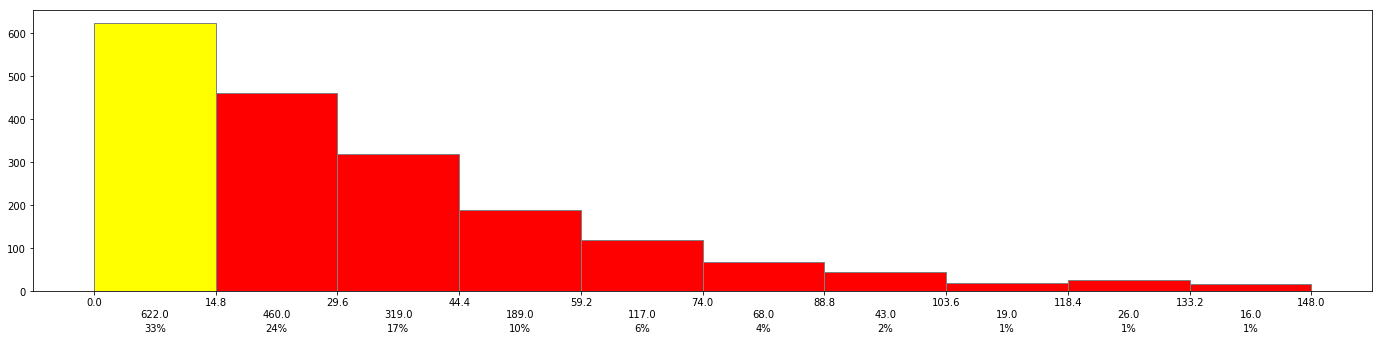

In [375]:
plotHist(list(numBallsRogue.values()))

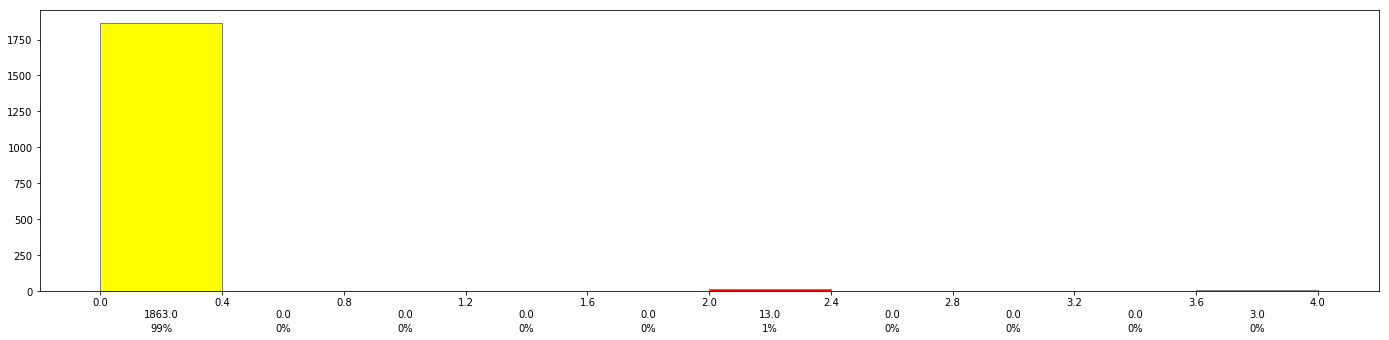

In [368]:
newNumBallsRogue = defaultdict(int)
for i, m in newData.items():
    comms1 = m['commentary']['innings1']['balls']
    comms2 = m['commentary']['innings2']['balls']
    newNumBallsRogue[i] += getNumRogueBalls(comms1) + getNumRogueBalls(comms1)

plotHist(list(newNumBallsRogue.values()))

In [382]:
m_ids = list(newNumBallsRogue.keys())
print(m_ids[399])

printInnings(newData, m_ids[399], 1, summaries=True)

291359
['END OF OVER:45 | 5 Runs 3 Wkts | INDIA: 194/10 | RR: 4.31', 'Ishant Sharma', '1 (1b)', 'Brett Lee', '9-2-27-5', 'Nathan Bracken', '9-0-55-1']
['END OF OVER:44 | 15 Runs | INDIA: 189/7 | RR: 4.29', 'Harbhajan Singh', '27 (18b)', 'MS Dhoni', '37 (60b)', 'Nathan Bracken', '9-0-55-1', 'Mitchell Johnson', '9-2-33-1']
['END OF OVER:43 | 7 Runs | INDIA: 174/7 | RR: 4.04', 'Harbhajan Singh', '15 (14b)', 'MS Dhoni', '34 (58b)', 'Mitchell Johnson', '9-2-33-1', 'Nathan Bracken', '8-0-40-1']
['END OF OVER:42 | 9 Runs | INDIA: 167/7 | RR: 3.97', 'MS Dhoni', '31 (55b)', 'Harbhajan Singh', '11 (11b)', 'Nathan Bracken', '8-0-40-1', 'James Hopes', '6-0-17-0']
['END OF OVER:41 | 6 Runs | INDIA: 158/7 | RR: 3.85', 'Harbhajan Singh', '5 (7b)', 'MS Dhoni', '29 (53b)', 'James Hopes', '6-0-17-0', 'Nathan Bracken', '7-0-31-1']
['END OF OVER:40 | 5 Runs | INDIA: 152/7 | RR: 3.80', 'MS Dhoni', '25 (50b)', 'Harbhajan Singh', '3 (4b)', 'Nathan Bracken', '7-0-31-1', 'Ashley Noffke', '9-0-46-1']
['END OF O